# Tracking the Growth of COVID-19 Cases in Japan

### データソース  
以下のダッシュボードのgithubで公開されているcsvを使用してます。

* 新型コロナウイルス感染速報  
https://covid-2019.live/

* csv  
https://raw.githubusercontent.com/swsoyee/2019-ncov-japan/master/Data/byDate.csv

In [1]:
# Now
! date

2020年  4月 10日 金曜日 20:17:21 JST


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

from matplotlib.dates import DateFormatter
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook  # If you switch from inline to notebook, you must restart the kernel!

#matplotlibで日本語フォントを使う設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


# データ・セット

In [3]:
# csv読み込み
df_raw = pd.read_csv( 'https://raw.githubusercontent.com/swsoyee/2019-ncov-japan/master/Data/byDate.csv')

# 全部 Nanの行は削除
if( df_raw.iloc[-1:,1:].isnull().all(axis=1).values[0] == True ):
    df_raw = df_raw.drop(df_raw.index.values[-1])
    print('drop [.isnull().all()] record')

# 日付に変換
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y%m%d')
days = df_raw['date'].dt.strftime('%m/%d/%y').values.tolist()

# 欠損値を0にする
df_raw = df_raw.fillna(0)

# 増加数と日本全体(クルーズ船とチャーター便を除く)
inc = df_raw
inc['日本全体'] = inc.drop(columns=['クルーズ船','チャーター便']).iloc[:,1:].sum(axis=1)

# 累積数を出す
tot = pd.concat( [inc.iloc[:,0:1], inc.iloc[:,1:].cumsum()], axis=1)

# 流用元(global版)と同じ構成になるよう
tmp = tot.set_index('date').T.reset_index()
tmp.columns.name = None
tmp = tmp.rename(columns={'index':'Country/Region'})
tmp['Province/State'] = np.nan
tmp['Lat'] = np.nan
tmp['Long'] = np.nan
df = pd.concat([tmp[['Province/State', 'Country/Region', 'Lat', 'Long']], tmp.iloc[:, 1:-3]], axis=1)
df.columns = df.columns[0:4].values.tolist() + days

In [4]:
 df.head()

,Province/State,Country/Region,Lat,Long,01/15/20,01/16/20,01/17/20,01/18/20,01/19/20,01/20/20,...,04/01/20,04/02/20,04/03/20,04/04/20,04/05/20,04/06/20,04/07/20,04/08/20,04/09/20,04/10/20
0,NaN,北海道,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,180.0,183.0,188.0,191.0,191.0,191.0,195.0,205.0,223.0,236.0
1,NaN,青森,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,9.0,11.0,11.0,11.0,11.0,12.0,12.0,14.0,17.0
2,NaN,岩手,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,宮城,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,12.0,18.0,20.0,23.0,26.0,32.0,34.0,36.0,38.0
4,NaN,秋田,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,9.0,10.0,11.0,11.0,11.0,11.0,11.0,11.0,12.0


In [5]:
df.head()

,Province/State,Country/Region,Lat,Long,01/15/20,01/16/20,01/17/20,01/18/20,01/19/20,01/20/20,...,04/01/20,04/02/20,04/03/20,04/04/20,04/05/20,04/06/20,04/07/20,04/08/20,04/09/20,04/10/20
0,NaN,北海道,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,180.0,183.0,188.0,191.0,191.0,191.0,195.0,205.0,223.0,236.0
1,NaN,青森,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,9.0,11.0,11.0,11.0,11.0,12.0,12.0,14.0,17.0
2,NaN,岩手,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,宮城,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,12.0,18.0,20.0,23.0,26.0,32.0,34.0,36.0,38.0
4,NaN,秋田,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,9.0,10.0,11.0,11.0,11.0,11.0,11.0,11.0,12.0


## COVID-19 Analysis

In [6]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
#cases = cases[cases[mostrecentdate] >= 100]
cases = cases[cases[mostrecentdate] >= 20]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 04/10/20


,04/10/20
Country/Region,
日本全体,5994.0
東京,1708.0
クルーズ船,712.0
大阪,616.0
神奈川,421.0


## Curve Fitting Global COVID-19 Cases

In [7]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



日本全体

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 5994.0
	Confirmed cases on 04/03/20 	 3113.0
	Ratio: 1.93
	Weekly increase: 92.5 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9947968018853458
	Doubling Time (during middle of growth):  15.3 (± 0.51 ) days
	param:  [1.28384337e+11 9.06332179e-02 4.40715774e+01 3.08745039e+11]

** Based on Exponential Fit **

	R^2: 0.9947968020415863
	Doubling Time (represents overall growth):  7.65 (± 0.25 ) days
	param:  [ 2.40485426  0.09063319 44.07145075]


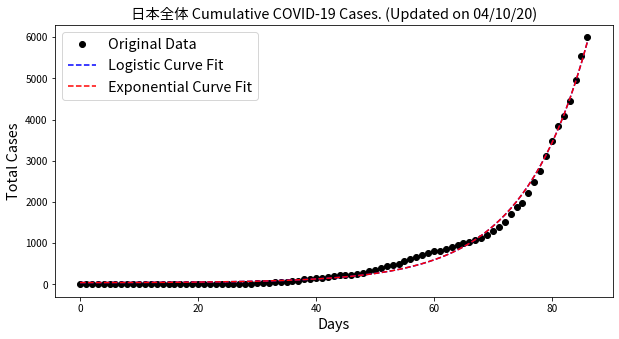



東京

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 1708.0
	Confirmed cases on 04/03/20 	 773.0
	Ratio: 2.21
	Weekly increase: 121.0 %
	Daily increase: 12.0 % per day
	Doubling Time (represents recent growth): 6.1 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9967719844171226
	Doubling Time (represents overall growth):  5.69 (± 0.15 ) days
	param:  [ 0.14658326  0.12173286 11.21096815]


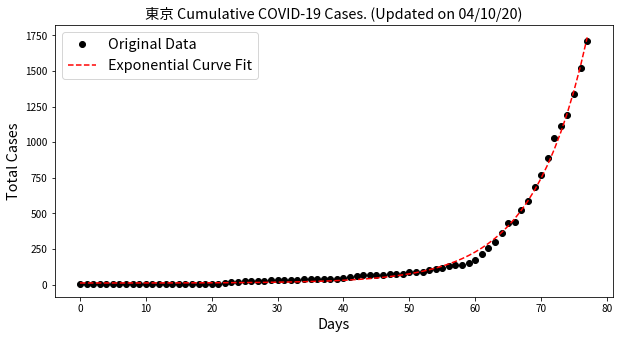



クルーズ船

** Based on Logistic Fit**

	R^2: 0.9951091097812745
	Doubling Time (during middle of growth):  3.22 (± 0.28 ) days
	param:  [1.04382453e+02 4.30847093e-01 3.89923811e+01 7.07721049e+02]

 exponential R^2  -0.22800703672297318


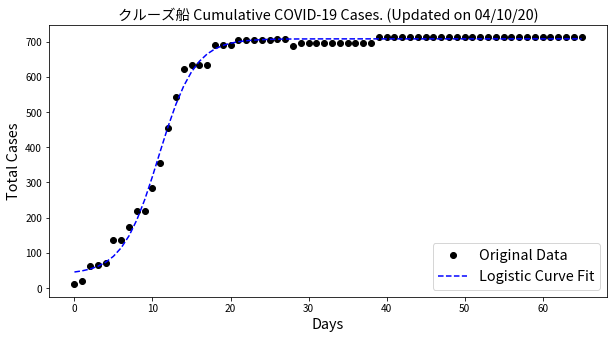



大阪

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 616.0
	Confirmed cases on 04/03/20 	 346.0
	Ratio: 1.78
	Weekly increase: 78.0 %
	Daily increase: 8.6 % per day
	Doubling Time (represents recent growth): 8.4 days

** Based on Logistic Fit**

	R^2: 0.9888381972965211
	Doubling Time (during middle of growth):  16.85 (± 0.65 ) days
	param:  [ 7.04346864e+09  8.22702250e-02 -2.37430333e+00  1.16920645e+10]

** Based on Exponential Fit **

	R^2: 0.9888381977090225
	Doubling Time (represents overall growth):  8.43 (± 0.47 ) days
	param:  [ 1.66000433  0.08227007 -2.37444404]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



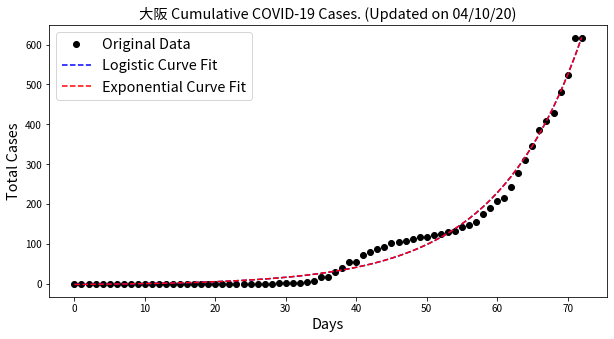



神奈川

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 421.0
	Confirmed cases on 04/03/20 	 217.0
	Ratio: 1.94
	Weekly increase: 94.0 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9887577151089691
	Doubling Time (during middle of growth):  14.77 (± 0.73 ) days
	param:  [1.96686506e+11 9.38639565e-02 6.66104167e+00 2.45303432e+10]

** Based on Exponential Fit **

	R^2: 0.9887577153089391
	Doubling Time (represents overall growth):  7.38 (± 0.36 ) days
	param:  [0.12471937 0.09386382 6.66099341]


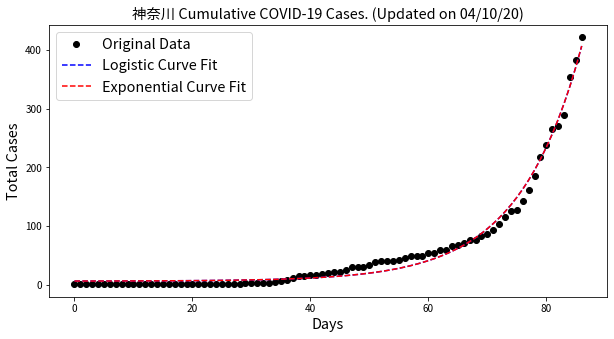



千葉

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 387.0
	Confirmed cases on 04/03/20 	 210.0
	Ratio: 1.84
	Weekly increase: 84.3 %
	Daily increase: 9.1 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9890284524759693
	Doubling Time (during middle of growth):  8.85 (± 1.21 ) days
	param:  [3.76676960e+04 1.56623689e-01 7.39329645e+00 6.17433227e+02]

** Based on Exponential Fit **

	R^2: 0.9847703331617994
	Doubling Time (represents overall growth):  6.89 (± 0.44 ) days
	param:  [0.34980681 0.10060598 2.14961061]


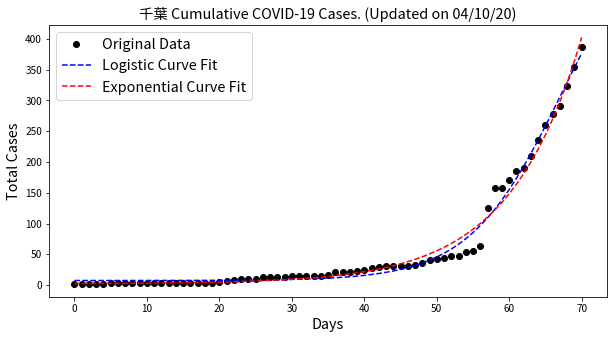



兵庫

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 316.0
	Confirmed cases on 04/03/20 	 175.0
	Ratio: 1.81
	Weekly increase: 80.6 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9659350150078218
	Doubling Time (during middle of growth):  37.56 (± 23.91 ) days
	param:  [ 3.05086605e+07  3.69040213e-02 -7.84723614e+01  2.45520626e+09]

** Based on Exponential Fit **

	R^2: 0.9659350160454473
	Doubling Time (represents overall growth):  18.78 (± 6.06 ) days
	param:  [ 8.04750279e+01  3.69041862e-02 -7.84715535e+01]


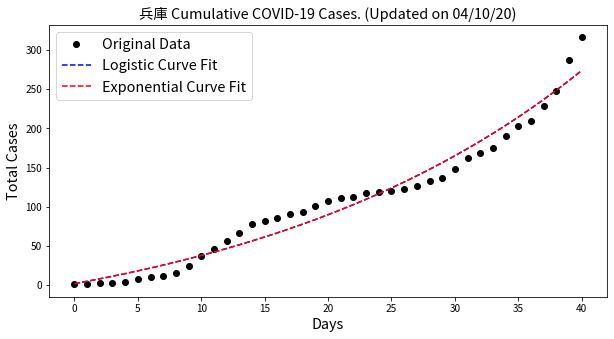



愛知

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 300.0
	Confirmed cases on 04/03/20 	 201.0
	Ratio: 1.49
	Weekly increase: 49.3 %
	Daily increase: 5.9 % per day
	Doubling Time (represents recent growth): 12.1 days

** Based on Logistic Fit**

	R^2: 0.9766764159846705
	Doubling Time (during middle of growth):  31.73 (± 13.74 ) days
	param:  [ 5.40328473e+01  4.36834987e-02 -2.77109280e+01  9.09436513e+02]

** Based on Exponential Fit **

	R^2: 0.9762908161302004
	Doubling Time (represents overall growth):  21.15 (± 2.69 ) days
	param:  [ 2.80782165e+01  3.27697951e-02 -4.09124323e+01]


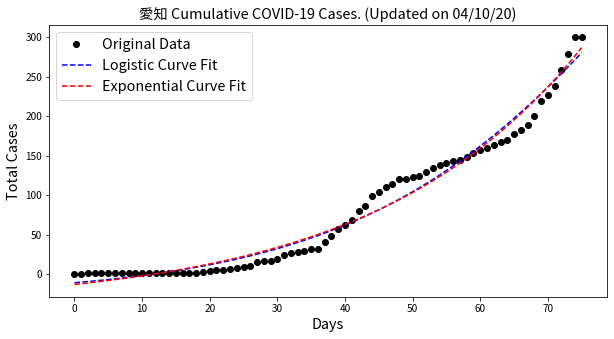



埼玉

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 296.0
	Confirmed cases on 04/03/20 	 135.0
	Ratio: 2.19
	Weekly increase: 119.3 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.993510164724038
	Doubling Time (during middle of growth):  13.43 (± 0.95 ) days
	param:  [6.25844161e+09 1.03242877e-01 2.55967956e-01 1.19128728e+10]

** Based on Exponential Fit **

	R^2: 0.9935101648870488
	Doubling Time (represents overall growth):  6.71 (± 0.37 ) days
	param:  [1.90349191 0.10324284 0.25594973]


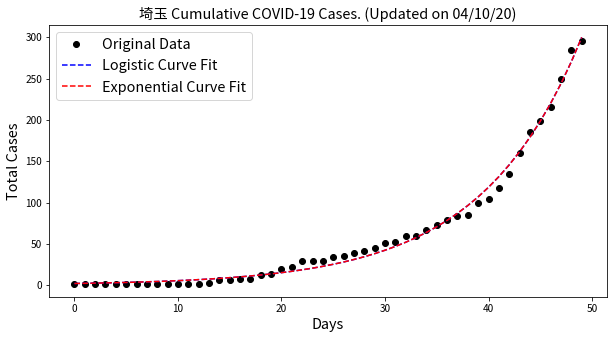



福岡

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 289.0
	Confirmed cases on 04/03/20 	 119.0
	Ratio: 2.43
	Weekly increase: 142.9 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9948358875997302
	Doubling Time (during middle of growth):  4.5 (± 0.47 ) days
	param:  [1.20465476e+06 3.07973821e-01 1.97816190e+00 3.40066050e+02]

** Based on Exponential Fit **

	R^2: 0.9801875722768154
	Doubling Time (represents overall growth):  4.42 (± 0.38 ) days
	param:  [ 0.12027557  0.1569895  -2.12188279]


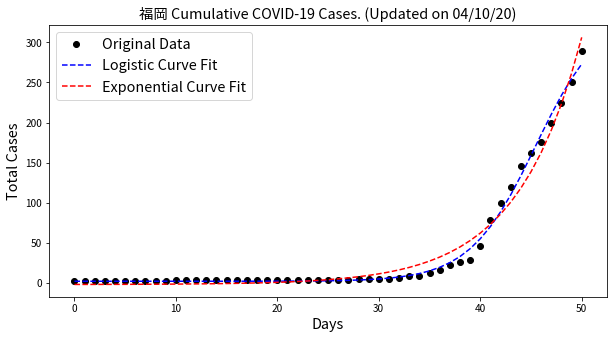



北海道

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 236.0
	Confirmed cases on 04/03/20 	 188.0
	Ratio: 1.26
	Weekly increase: 25.5 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.3 days

** Based on Logistic Fit**

	R^2: 0.985616831498071
	Doubling Time (during middle of growth):  12.14 (± 1.62 ) days
	param:  [ 8.42832735e+01  1.14210721e-01 -9.01177958e+00  1.99025828e+02]

 exponential R^2  0.9415791541105397


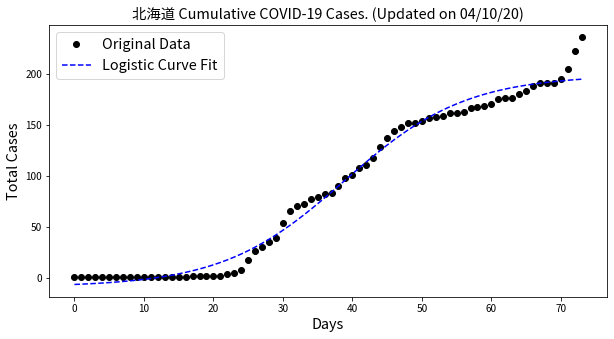



京都

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 174.0
	Confirmed cases on 04/03/20 	 106.0
	Ratio: 1.64
	Weekly increase: 64.2 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.8 days

** Based on Logistic Fit**

	R^2: 0.9916314445400563
	Doubling Time (during middle of growth):  9.33 (± 1.14 ) days
	param:  [3.49233575e+04 1.48615561e-01 3.17444244e+00 3.41001029e+02]

** Based on Exponential Fit **

	R^2: 0.9887046894850116
	Doubling Time (represents overall growth):  6.78 (± 0.37 ) days
	param:  [0.13265235 0.10216843 0.96361597]


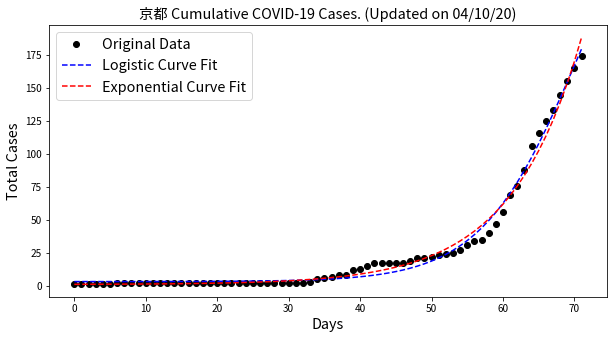



検疫職員

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 96.0
	Confirmed cases on 04/03/20 	 75.0
	Ratio: 1.28
	Weekly increase: 28.0 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.7 days

** Based on Logistic Fit**

	R^2: 0.9881511404985879
	Doubling Time (during middle of growth):  8.89 (± 1.32 ) days
	param:  [2.07840390e+03 1.56017496e-01 5.70154779e+00 1.21104397e+02]

** Based on Exponential Fit **

	R^2: 0.9766637218323782
	Doubling Time (represents overall growth):  10.07 (± 1.06 ) days
	param:  [ 1.99684831  0.0688284  -0.18862799]


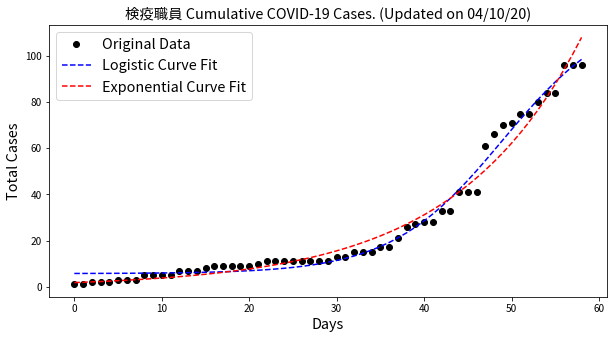



石川

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 92.0
	Confirmed cases on 04/03/20 	 24.0
	Ratio: 3.83
	Weekly increase: 283.3 %
	Daily increase: 21.2 % per day
	Doubling Time (represents recent growth): 3.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9866518741151915
	Doubling Time (represents overall growth):  3.27 (± 0.23 ) days
	param:  [2.71779608e-03 2.12011738e-01 5.27723969e+00]


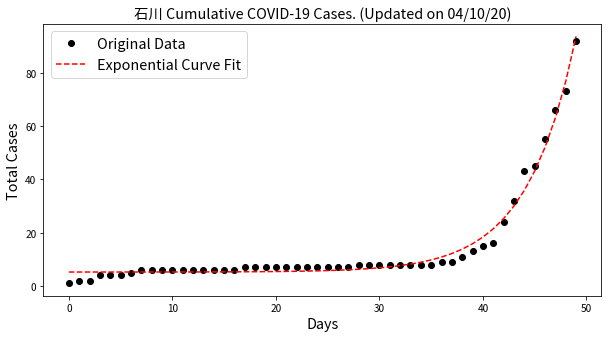



岐阜

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 91.0
	Confirmed cases on 04/03/20 	 40.0
	Ratio: 2.28
	Weekly increase: 127.5 %
	Daily increase: 12.5 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9971937125434727
	Doubling Time (during middle of growth):  7.38 (± 0.69 ) days
	param:  [3.26604235e+03 1.87942186e-01 1.27885589e+00 1.68284332e+02]

** Based on Exponential Fit **

	R^2: 0.9928917652737669
	Doubling Time (represents overall growth):  5.47 (± 0.32 ) days
	param:  [ 0.36929428  0.12674637 -0.33281569]


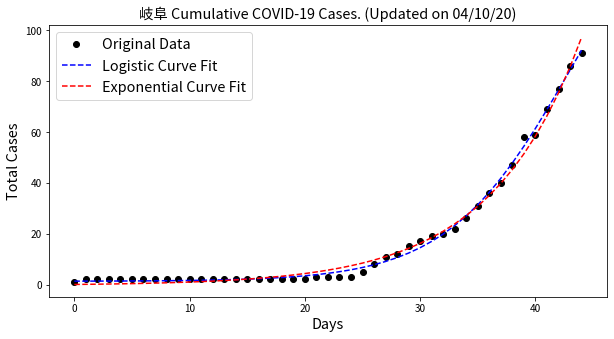



茨城

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 91.0
	Confirmed cases on 04/03/20 	 54.0
	Ratio: 1.69
	Weekly increase: 68.5 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.3 days

** Based on Logistic Fit**

	R^2: 0.9927035353202459
	Doubling Time (during middle of growth):  4.23 (± 0.76 ) days
	param:  [235.46643536   0.32803831   2.47754257  94.26628797]

** Based on Exponential Fit **

	R^2: 0.97069219900668
	Doubling Time (represents overall growth):  8.57 (± 2.62 ) days
	param:  [ 16.78661767   0.08087907 -20.15507054]


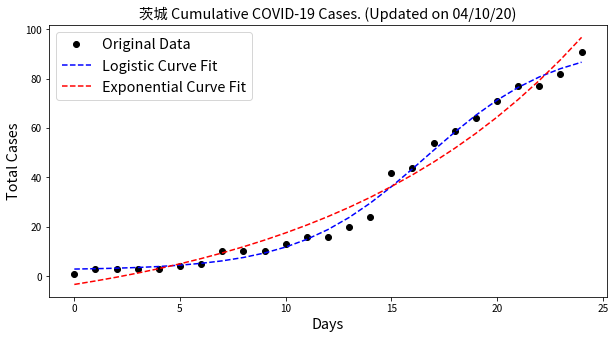



福井

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 82.0
	Confirmed cases on 04/03/20 	 42.0
	Ratio: 1.95
	Weekly increase: 95.2 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.996712837132311
	Doubling Time (during middle of growth):  4.64 (± 0.63 ) days
	param:  [ 1.83944110e+02  2.98979613e-01 -1.72066018e-01  9.69797142e+01]

** Based on Exponential Fit **

	R^2: 0.9817492595406558
	Doubling Time (represents overall growth):  6.71 (± 1.4 ) days
	param:  [  9.50216826   0.10331898 -13.45053565]


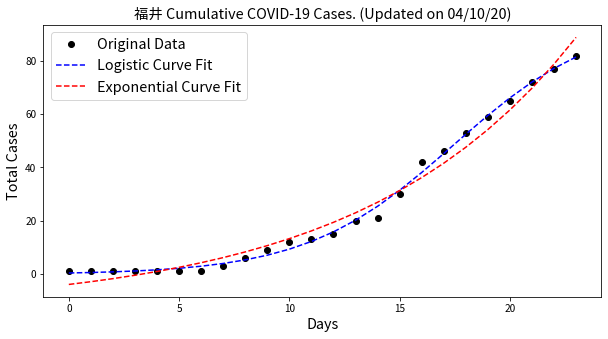



高知

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 54.0
	Confirmed cases on 04/03/20 	 23.0
	Ratio: 2.35
	Weekly increase: 134.8 %
	Daily increase: 13.0 % per day
	Doubling Time (represents recent growth): 5.7 days

 logistic R^2  0.945240312484085

 exponential R^2  0.9452403150607552


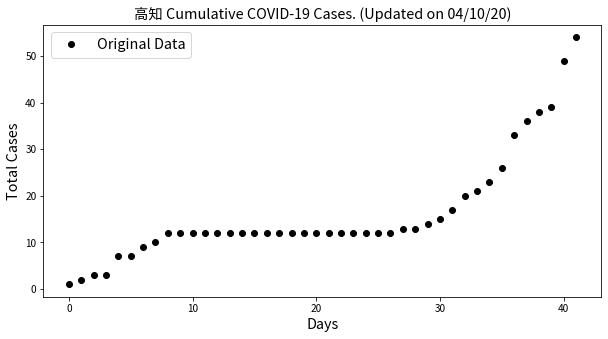



沖縄

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 48.0
	Confirmed cases on 04/03/20 	 11.0
	Ratio: 4.36
	Weekly increase: 336.4 %
	Daily increase: 23.4 % per day
	Doubling Time (represents recent growth): 3.3 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9816135501311061
	Doubling Time (represents overall growth):  3.35 (± 0.25 ) days
	param:  [4.48000074e-04 2.06628426e-01 2.65996960e+00]


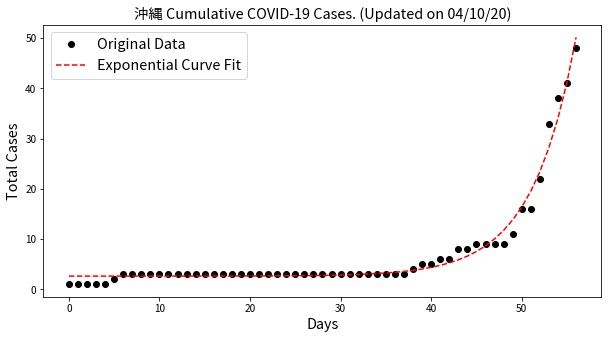



群馬

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 42.0
	Confirmed cases on 04/03/20 	 25.0
	Ratio: 1.68
	Weekly increase: 68.0 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.9708437615900251
	Doubling Time (during middle of growth):  33.96 (± 6.94 ) days
	param:  [ 3.01008008e+07  4.08222159e-02 -1.05146465e+01  3.45410505e+08]

** Based on Exponential Fit **

	R^2: 0.9708437621782054
	Doubling Time (represents overall growth):  16.98 (± 5.8 ) days
	param:  [ 11.47500967   0.04082244 -10.51451079]


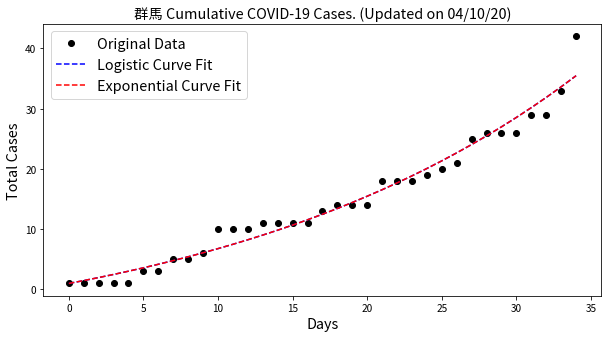



新潟

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 41.0
	Confirmed cases on 04/03/20 	 35.0
	Ratio: 1.17
	Weekly increase: 17.1 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.7 days

** Based on Logistic Fit**

	R^2: 0.9848852560034961
	Doubling Time (during middle of growth):  14.51 (± 5.0 ) days
	param:  [  3.75539433   0.09554113 -10.06796261  41.76599331]

** Based on Exponential Fit **

	R^2: 0.9606971807985246
	Doubling Time (represents overall growth):  84.64 (± 122.16 ) days
	param:  [ 1.00000000e+02  8.18953934e-03 -9.68399115e+01]


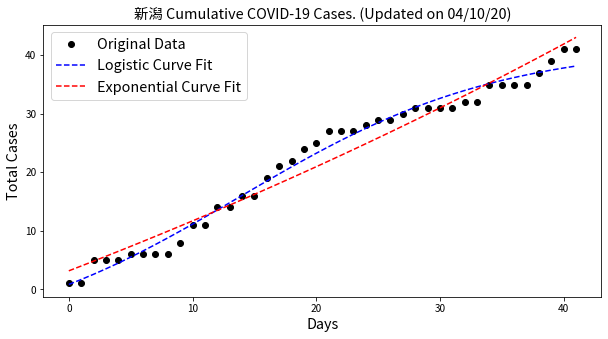



大分

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 41.0
	Confirmed cases on 04/03/20 	 31.0
	Ratio: 1.32
	Weekly increase: 32.3 %
	Daily increase: 4.1 % per day
	Doubling Time (represents recent growth): 17.4 days

** Based on Logistic Fit**

	R^2: 0.9588670352325475
	Doubling Time (during middle of growth):  4.12 (± 1.29 ) days
	param:  [ 7.76857316e+02  3.36202318e-01 -1.69661721e-01  3.43960560e+01]

 exponential R^2  0.9134125580969449


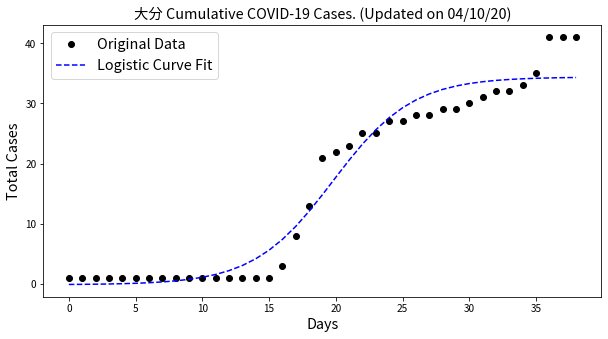



宮城

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 38.0
	Confirmed cases on 04/03/20 	 18.0
	Ratio: 2.11
	Weekly increase: 111.1 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.997469628545268
	Doubling Time (during middle of growth):  3.66 (± 0.28 ) days
	param:  [6.65090106e+05 3.78586617e-01 8.68920495e-01 4.23055505e+01]

** Based on Exponential Fit **

	R^2: 0.9682027963270099
	Doubling Time (represents overall growth):  4.52 (± 0.57 ) days
	param:  [ 0.08129085  0.15327626 -0.17097402]


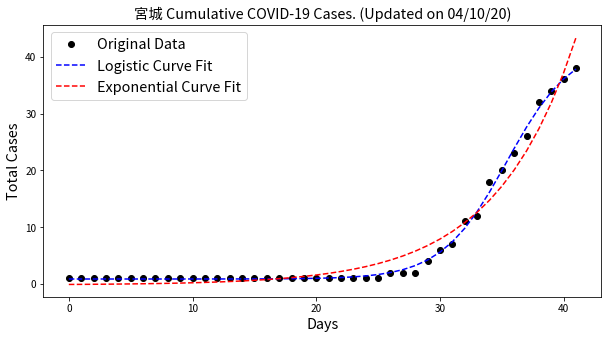



奈良

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 37.0
	Confirmed cases on 04/03/20 	 21.0
	Ratio: 1.76
	Weekly increase: 76.2 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9613546058511258
	Doubling Time (during middle of growth):  16.68 (± 2.68 ) days
	param:  [8.26898392e+09 8.30904879e-02 1.04142586e+00 6.62480535e+08]

** Based on Exponential Fit **

	R^2: 0.9613546065830025
	Doubling Time (represents overall growth):  8.34 (± 0.87 ) days
	param:  [0.08011849 0.0830901  1.04140645]


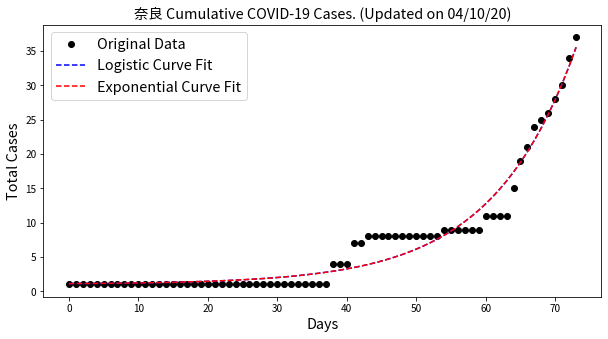



和歌山

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 37.0
	Confirmed cases on 04/03/20 	 22.0
	Ratio: 1.68
	Weekly increase: 68.2 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.3 days

 logistic R^2  0.8430030349376032

 exponential R^2  0.8430030390095826


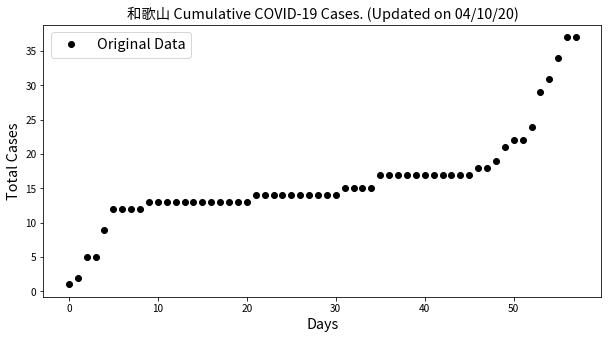



静岡

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 37.0
	Confirmed cases on 04/03/20 	 16.0
	Ratio: 2.31
	Weekly increase: 131.2 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.9788774817253146
	Doubling Time (during middle of growth):  7.73 (± 2.29 ) days
	param:  [5.51310848e+03 1.79241633e-01 1.41782325e+00 1.43180014e+02]

** Based on Exponential Fit **

	R^2: 0.9783671575116383
	Doubling Time (represents overall growth):  4.51 (± 0.46 ) days
	param:  [0.05757036 0.1537305  1.20963073]


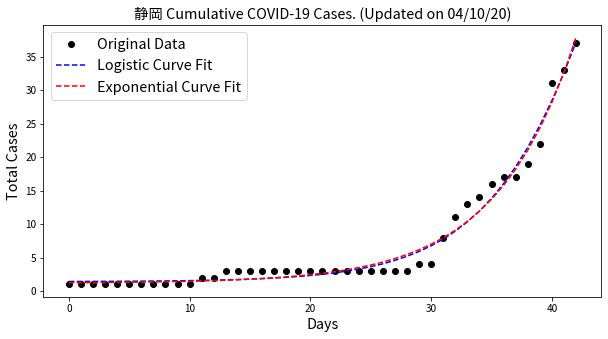



福島

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 35.0
	Confirmed cases on 04/03/20 	 9.0
	Ratio: 3.89
	Weekly increase: 288.9 %
	Daily increase: 21.4 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9916195393141976
	Doubling Time (during middle of growth):  3.64 (± 0.61 ) days
	param:  [1.43052311e+05 3.80765854e-01 1.49939407e+00 4.74355871e+01]

** Based on Exponential Fit **

	R^2: 0.9786484300072779
	Doubling Time (represents overall growth):  3.41 (± 0.38 ) days
	param:  [0.03735033 0.20349724 0.85830082]


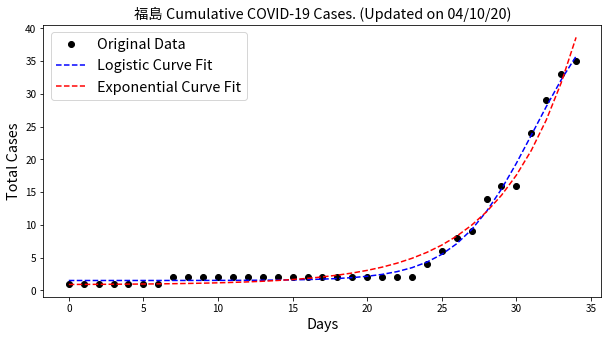



滋賀

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 34.0
	Confirmed cases on 04/03/20 	 14.0
	Ratio: 2.43
	Weekly increase: 142.9 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9779401295915234
	Doubling Time (during middle of growth):  8.81 (± 3.48 ) days
	param:  [5.88715528e+04 1.57338527e-01 1.52597679e+00 7.01202375e+03]

** Based on Exponential Fit **

	R^2: 0.9779400303324534
	Doubling Time (represents overall growth):  4.42 (± 0.51 ) days
	param:  [0.12061434 0.15685849 1.52012995]


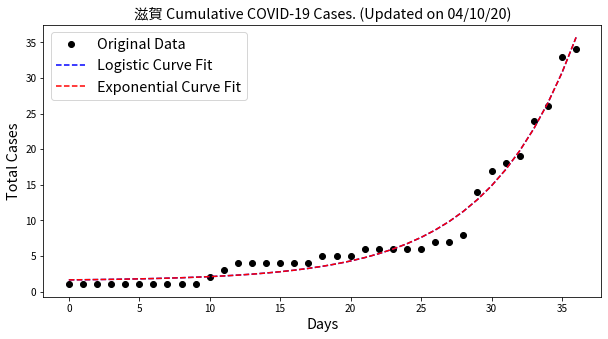



山形

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 32.0
	Confirmed cases on 04/03/20 	 8.0
	Ratio: 4.0
	Weekly increase: 300.0 %
	Daily increase: 21.9 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.9867044138484834
	Doubling Time (during middle of growth):  18.66 (± 239.93 ) days
	param:  [ 3.13155509e+01  7.42740842e-02 -3.02629794e+01  9.50574568e+02]

** Based on Exponential Fit **

	R^2: 0.9867040797229664
	Doubling Time (represents overall growth):  10.26 (± 8.87 ) days
	param:  [ 32.49672506   0.06753903 -32.41523049]


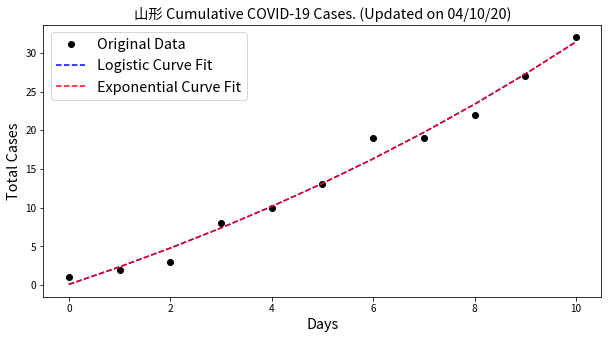



栃木

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 31.0
	Confirmed cases on 04/03/20 	 17.0
	Ratio: 1.82
	Weekly increase: 82.4 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.9657950820136865
	Doubling Time (during middle of growth):  14.65 (± 7.08 ) days
	param:  [6.89740000e+02 9.46192799e-02 1.54710230e-01 2.50740053e+02]

** Based on Exponential Fit **

	R^2: 0.9657252410155146
	Doubling Time (represents overall growth):  7.89 (± 1.09 ) days
	param:  [ 0.44916676  0.08783725 -0.00256393]


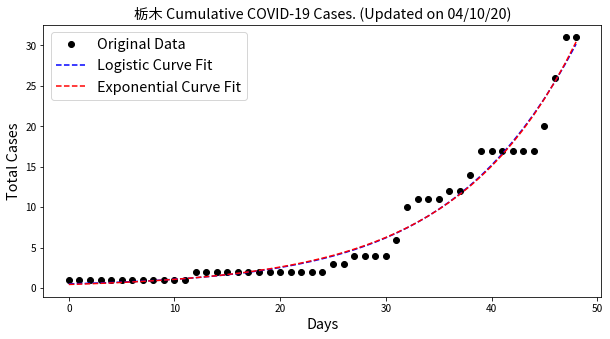



山梨

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 30.0
	Confirmed cases on 04/03/20 	 11.0
	Ratio: 2.73
	Weekly increase: 172.7 %
	Daily increase: 15.4 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9940091991028503
	Doubling Time (during middle of growth):  5.1 (± 0.75 ) days
	param:  [8.30352184e+03 2.71864487e-01 1.95760894e+00 4.77462568e+01]

** Based on Exponential Fit **

	R^2: 0.987993807974788
	Doubling Time (represents overall growth):  4.15 (± 0.35 ) days
	param:  [0.08842696 0.16710808 1.36684446]


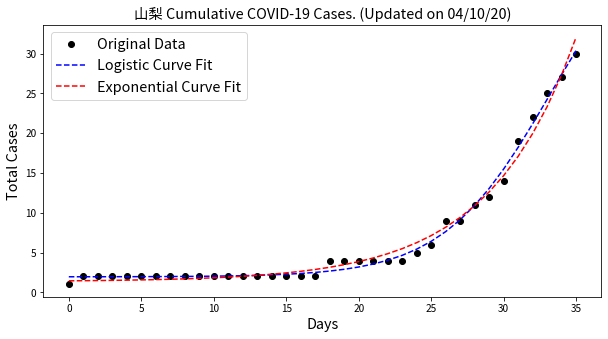



広島

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 29.0
	Confirmed cases on 04/03/20 	 13.0
	Ratio: 2.23
	Weekly increase: 123.1 %
	Daily increase: 12.1 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9882998822898061
	Doubling Time (during middle of growth):  7.61 (± 1.96 ) days
	param:  [8.67886149e+02 1.82275553e-01 8.19810909e-01 7.82044918e+01]

** Based on Exponential Fit **

	R^2: 0.9871606728450211
	Doubling Time (represents overall growth):  4.9 (± 0.46 ) days
	param:  [0.23688295 0.14156804 0.38808494]


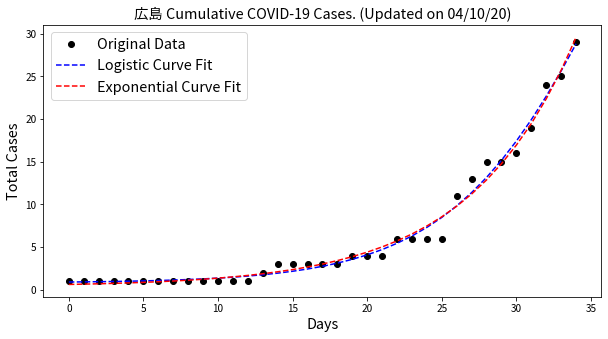



長野

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 28.0
	Confirmed cases on 04/03/20 	 10.0
	Ratio: 2.8
	Weekly increase: 180.0 %
	Daily increase: 15.8 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9728145245443914
	Doubling Time (during middle of growth):  9.13 (± nan ) days
	param:  [2.17937809e+10 1.51920796e-01 2.66750231e+00 5.22660394e+08]

** Based on Exponential Fit **

	R^2: 0.9728145254494065
	Doubling Time (represents overall growth):  4.56 (± 0.5 ) days
	param:  [0.02398297 0.15191995 2.66748914]


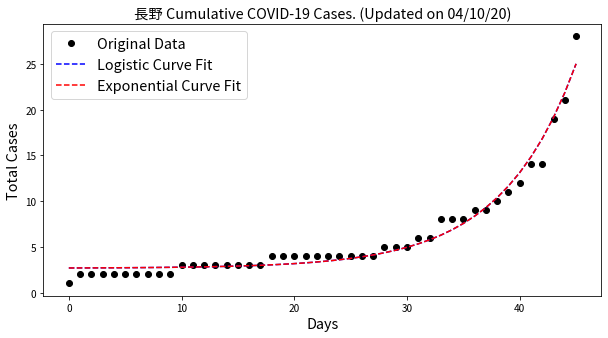



愛媛

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 28.0
	Confirmed cases on 04/03/20 	 19.0
	Ratio: 1.47
	Weekly increase: 47.4 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.5 days

** Based on Logistic Fit**

	R^2: 0.9889295147770605
	Doubling Time (during middle of growth):  2.66 (± 0.44 ) days
	param:  [1.30074420e+07 5.21668215e-01 2.22536087e+00 2.67120260e+01]

 exponential R^2  0.941042790978662


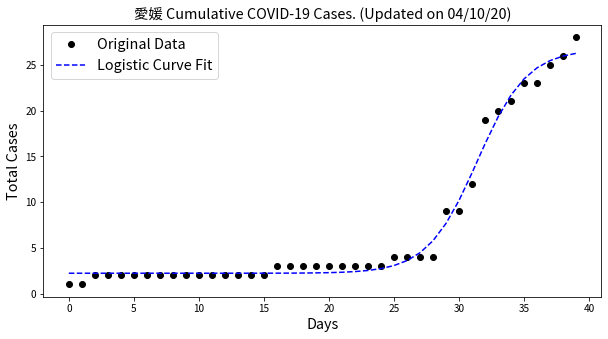



熊本

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 24.0
	Confirmed cases on 04/03/20 	 18.0
	Ratio: 1.33
	Weekly increase: 33.3 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 16.9 days

** Based on Logistic Fit**

	R^2: 0.9752583907339932
	Doubling Time (during middle of growth):  7.99 (± 1.96 ) days
	param:  [1.63014365e+03 1.73425617e-01 4.83690142e+00 3.01521308e+01]

** Based on Exponential Fit **

	R^2: 0.9685970341611573
	Doubling Time (represents overall growth):  8.26 (± 1.09 ) days
	param:  [0.35433663 0.08392598 3.78286455]


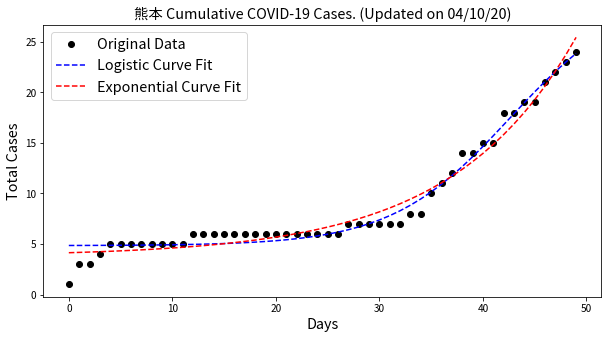



富山

** Based on Most Recent Week of Data **

	Confirmed cases on 04/10/20 	 23.0
	Confirmed cases on 04/03/20 	 8.0
	Ratio: 2.88
	Weekly increase: 187.5 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

 logistic R^2  0.9470676295396806

 exponential R^2  0.9470676305717673


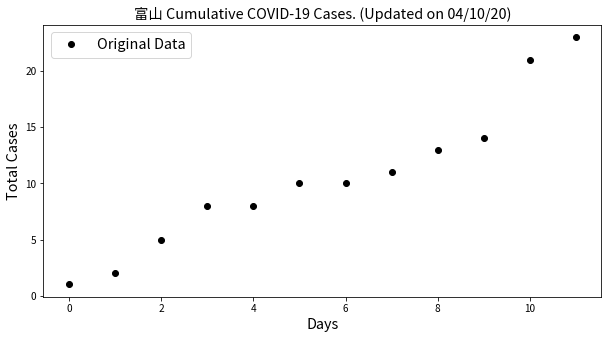

In [8]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


    Inferred Doubling Time  95%CI  Recent Doubling Time
0                      7.6    0.3                   7.4
1                      5.7    0.2                   6.1
2                      3.2    0.3                   NaN
3                      8.4    0.5                   8.4
4                      7.4    0.4                   7.3
5                      8.9    1.2                   7.9
6                     18.8    6.1                   8.2
7                     21.2    2.7                  12.1
8                      6.7    0.4                   6.2
9                      4.5    0.5                   5.5
10                    12.1    1.6                  21.3
11                     6.8    0.4                   9.8
12                     8.9    1.3                  19.7
13      

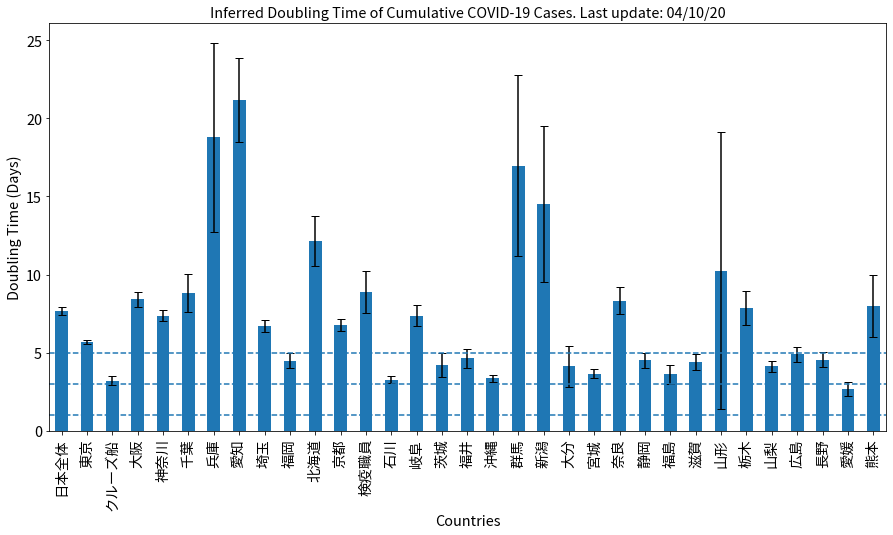

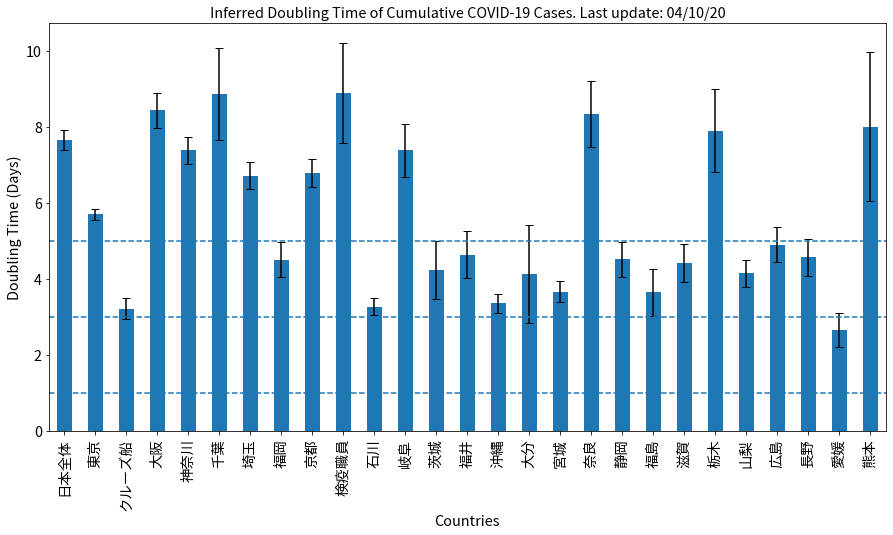

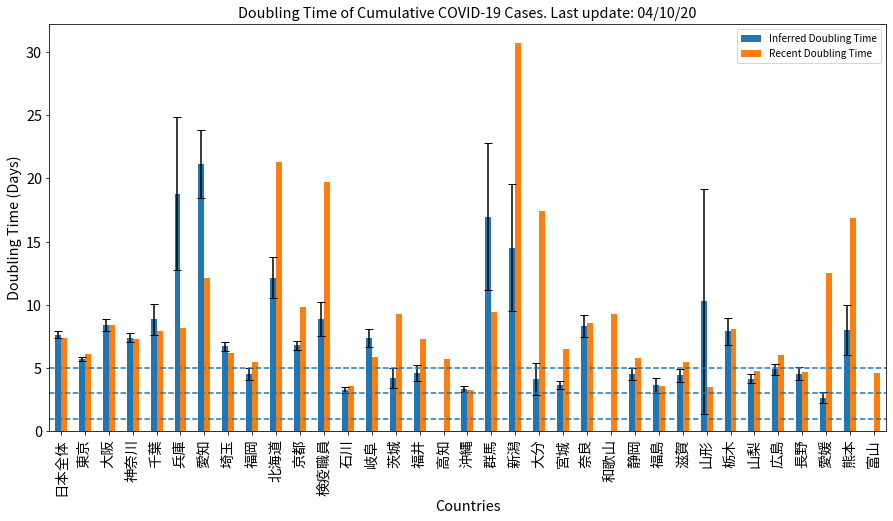

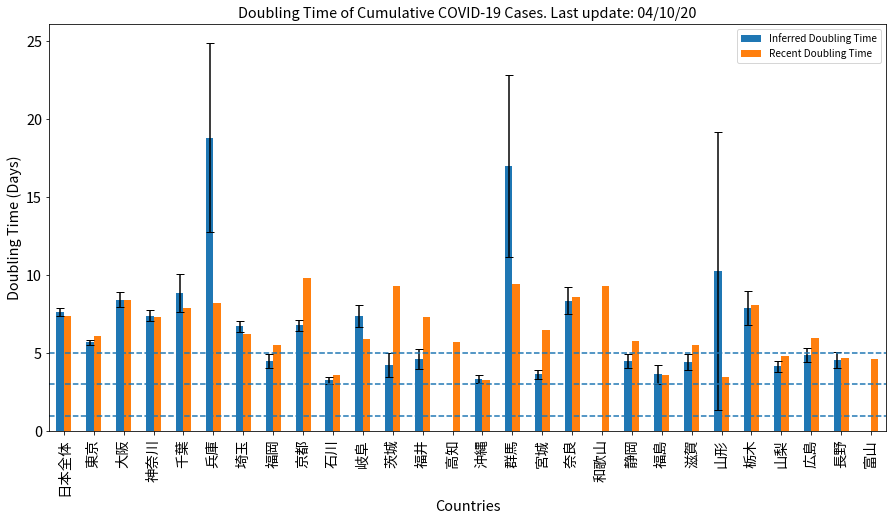

In [9]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()